In [10]:
from spyglass.ripple.v1 import RippleTimesV1, RippleParameters
from spyglass.common import interval_list_intersect
import numpy as np
from scipy.stats import ttest_rel

import os
import matplotlib.pyplot as plt

os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from ms_opto_stim_protocol import OptoStimProtocol
from Analysis.utils import filter_opto_data, violin_scatter
from Style.style_guide import animal_style, interval_style

from spyglass.position.v1 import TrodesPosV1
from spyglass.position import PositionOutput

## W-track. Run Sessions

In [11]:
ripple_key = {
    "nwb_file_name": nwb_file_name,
    "target_interval_list_name": f"{nwb_file_name}_{interval_list_name}_LFP_default_difference",
}
RippleTimesV1() & ripple_key

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,group_name,ripple_param_name a name for this set of parameters,pos_merge_id,analysis_file_name name of the file,ripple_times_object_id
f4da42fb-9e40-3ae2-940e-e915b2cf2fd0,Ripple 150-250 Hz,1000,Yoshi20220518_.nwb,Yoshi20220518_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,default_ms,22200ad8-6657-30e2-45ea-333524af61f5,Yoshi20220518_W5OC0H6DN6.nwb,1d1f266c-f630-4f37-a286-f2e8312d21bc
f4da42fb-9e40-3ae2-940e-e915b2cf2fd0,Ripple 150-250 Hz,1000,Yoshi20220518_.nwb,Yoshi20220518_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,default_ms,60786e4d-8fe9-c1ec-41ec-448a29b0ef51,Yoshi20220518_ZQZJVX3QFH.nwb,60aad834-ff04-4a69-999a-eb27fe078897


datasets: 9
datasets: 9
No ripples for {'nwb_file_name': 'Frodo20230814_.nwb', 'target_interval_list_name': 'pos 1 valid times_ms_lfp_artifact_times'}
datasets: 10
datasets: 16
datasets: 8
datasets: 10
datasets: 8
datasets: 16
No ripples for {'nwb_file_name': 'Yoshi20220518_.nwb', 'target_interval_list_name': 'pos 15 valid times_ms_lfp_artifact_times'}


Text(0.5, 0.98, 'Ripple Rate During Run epochs')

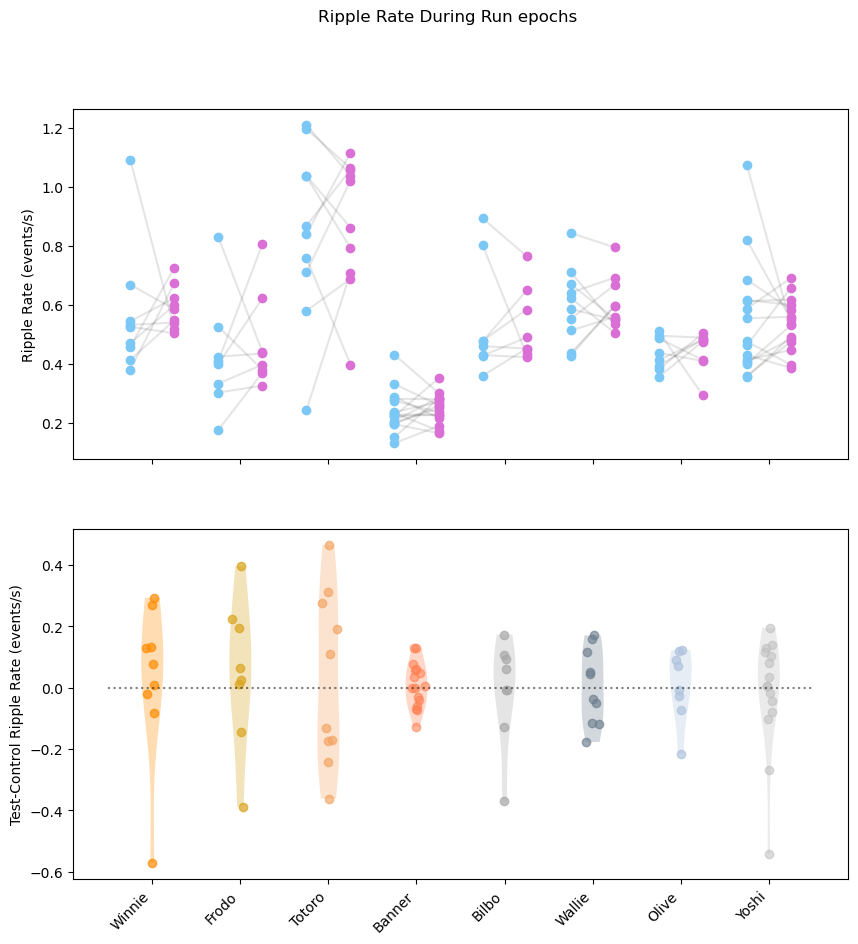

In [12]:
animal_list = [
    "Winnie",
    "Frodo",
    "Totoro",
    "Banner",
    "Bilbo",
    "Wallie",
    "Olive",
    "Yoshi",
]
# animal_list = ["Winnie","Yoshi"]
# animal_list = ["Yoshi"]

filter_speed = True
dlc_pos = True
artifact_detection = "ms_lfp_artifact_times"


fig, ax = plt.subplots(figsize=(10, 10), nrows=2, sharex=True)
ripple_lengths = {}
ripple_rates = {}
for animal in animal_list:
    ripple_lengths[animal] = {"test": [], "control": []}
    ripple_rates[animal] = {"test": [], "control": []}

for loc, animal in enumerate(animal_list):
    dataset_key = {
        "animal": animal,
        #    "period_ms":80,
        "targeted_phase": 90,
        "min_pulse_length": 20,
        "track_type": "early_wtrack",
    }

    dataset = filter_opto_data(
        dataset_key,
    )
    nwb_file_names = dataset.fetch("nwb_file_name")
    interval_list_names = dataset.fetch("interval_list_name")

    test_ripple_rate = []
    control_ripple_rate = []
    for nwb_file_name, interval_list_name in zip(nwb_file_names, interval_list_names):
        basic_key = {
            "nwb_file_name": nwb_file_name,
            "interval_list_name": interval_list_name,
        }
        ripple_key = {
            "nwb_file_name": nwb_file_name,
            # "target_interval_list_name": f"{nwb_file_name}_{interval_list_name}_{artifact_detection}",
            "target_interval_list_name": f"{interval_list_name}_{artifact_detection}",
        }

        if dlc_pos:
            query = (
                RippleTimesV1()
                & ripple_key
                & PositionOutput.DLCPosV1().proj(pos_merge_id="merge_id")
            )
        else:
            query = (
                RippleTimesV1()
                & ripple_key
                & PositionOutput.TrodesV1().proj(pos_merge_id="merge_id")
            )
        if not query:
            print("No ripples for {}".format(ripple_key))
            continue
        ripple_key = query.fetch1("KEY")

        ripple_df = (RippleTimesV1() & ripple_key).fetch1_dataframe()
        all_ripples = [
            [start, end] for start, end in zip(ripple_df.start_time, ripple_df.end_time)
        ]
        control_intervals = (OptoStimProtocol & basic_key).fetch1("control_intervals")
        test_intervals = (OptoStimProtocol & basic_key).fetch1("test_intervals")

        control_ripples = interval_list_intersect(
            np.array(all_ripples), np.array(control_intervals)
        )
        test_ripples = interval_list_intersect(
            np.array(all_ripples), np.array(test_intervals)
        )

        # filter times when rat is stationary for rate calculation
        if filter_speed:
            # get the threshold speed from the ripple calculation
            ripple_param_name = (RippleTimesV1() & ripple_key).fetch1(
                "ripple_param_name"
            )
            thresh_speed = (
                RippleParameters() & {"ripple_param_name": ripple_param_name}
            ).fetch1("ripple_param_dict")["ripple_detection_params"]["speed_threshold"]
            # get the speed over time
            # pos_df = (
            #     TrodesPosV1() & basic_key & {"trodes_pos_params_name": "single_led"}
            # ).fetch1_dataframe()
            pos_df = (
                PositionOutput() & {"merge_id": ripple_key["pos_merge_id"]}
            ).fetch1_dataframe()
            pos_time = pos_df.index.values
            pos_speed = pos_df.speed.values
            # make intervals where rat is stationary
            speed_binary = (pos_speed < thresh_speed).astype(int)
            speed_binary = np.append([0], speed_binary)
            if np.min(speed_binary) == 1:
                run_intervals = [(pos_time[0], pos_time[-1])]
            t_diff = np.diff(speed_binary)
            t_run_start = pos_time[np.where(t_diff == 1)[0]]
            t_run_stop = pos_time[np.where(t_diff == -1)[0]]
            stationary_intervals = [
                (start, stop) for start, stop in zip(t_run_start, t_run_stop)
            ]
            # restrict the intervals by this
            control_intervals = interval_list_intersect(
                np.array(control_intervals), np.array(stationary_intervals)
            )
            test_intervals = interval_list_intersect(
                np.array(test_intervals), np.array(stationary_intervals)
            )

        test_ripple_lengths = [end - start for start, end in test_ripples]
        control_ripple_lengths = [end - start for start, end in control_ripples]
        ripple_lengths[animal]["test"].extend(test_ripple_lengths)
        ripple_lengths[animal]["control"].extend(control_ripple_lengths)

        len_test = np.sum([end - start for start, end in test_intervals])
        len_control = np.sum([end - start for start, end in control_intervals])

        test_ripple_rate.append(len(test_ripple_lengths) / len_test)
        control_ripple_rate.append(len(control_ripple_lengths) / len_control)

        ripple_rates[animal]["test"].append(len(test_ripple_lengths) / len_test)
        ripple_rates[animal]["control"].append(
            len(control_ripple_lengths) / len_control
        )

        # if len(test_ripple_rate)>10:
        #     break

    if len(test_ripple_rate) == 0:
        continue
    ax[0].scatter(
        np.ones(len(test_ripple_rate)) * 2 * loc + 1,
        test_ripple_rate,
        color=interval_style["test"],
    )
    ax[0].scatter(
        np.ones(len(control_ripple_rate)) * 2 * loc,
        control_ripple_rate,
        color=interval_style["control"],
    )
    for test, control in zip(test_ripple_rate, control_ripple_rate):
        ax[0].plot(
            [2 * loc, 2 * loc + 1], [control, test], color="black", alpha=0.1, zorder=-1
        )

    violin_scatter(
        np.array(test_ripple_rate) - np.array(control_ripple_rate),
        pos=2 * loc + 0.5,
        color=animal_style.loc[animal, "color"],
    )

    p_val = ttest_rel(test_ripple_rate, control_ripple_rate).pvalue
    if p_val < 0.05:
        y_loc = 0.8
        ax[0].scatter([2 * loc + 0.5], [y_loc], color="k", marker="*")


plt.xticks(2 * np.arange(len(animal_list)) + 0.5, animal_list, rotation=45, ha="right")
plt.plot([-0.5, 2 * len(animal_list) - 0.5], [0, 0], color="black", ls=":", alpha=0.5)
ax[0].set_ylabel("Ripple Rate (events/s)")
ax[1].set_ylabel("Test-Control Ripple Rate (events/s)")
fig.suptitle("Ripple Rate During Run epochs")

In [31]:
ripple_rates[animal]  # [interval]

{'test': 0.4286516329269579, 'control': 0.39162492299797863}

### plot rates

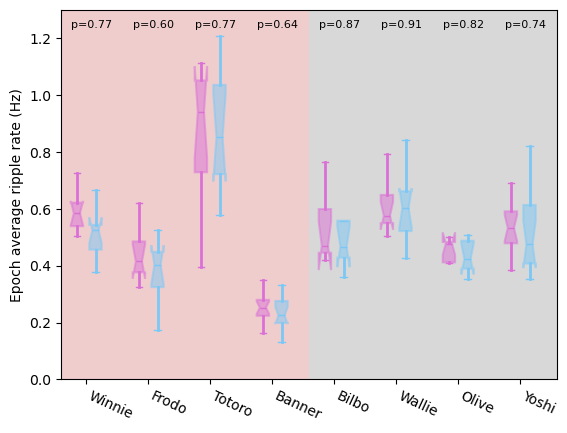

In [ ]:
from scipy.stats import ttest_rel

fig = plt.figure()
ax = fig.gca()
top = 0.75
top = 1.3
for i, animal in enumerate(ripple_lengths):
    c = animal_style.loc[animal, "color"]
    for j, interval in enumerate(["test", "control"]):
        c = interval_style[interval]
        plt.boxplot(
            ripple_rates[animal][interval],
            positions=[2 * i + j * 0.6],
            widths=0.4,
            patch_artist=True,
            showmeans=False,
            # showmedians=False,
            boxprops=dict(facecolor=c, alpha=0.5, edgecolor=c, lw=1.5),
            capprops=dict(color=c),
            whiskerprops=dict(color=c, lw=2),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            notch=True,
            showfliers=False,
        )

    plt.fill_between(
        [2 * i - 0.5, 2 * (i + 1) - 0.5],
        0,
        top + 1,
        facecolor=animal_style.loc[animal, "background"],
        alpha=0.3,
        zorder=-1,
    )

    p_val = ttest_rel(
        ripple_rates[animal]["test"], ripple_rates[animal]["control"]
    ).pvalue
    plt.text(2 * i - 0.2, 0.95 * top, f"p={p_val:.2f}", fontsize=8)
    loc = np.max([ripple_rates[animal]["test"], ripple_rates[animal]["control"]]) + 0.02
    if p_val < 0.05:
        ax.plot([2 * i, 2 * i + 1], [loc, loc], color="black", alpha=0.5, zorder=-1)
        plt.scatter([2 * i + 0.5], [loc + 0.02], color="black", marker="*")

ax.set_ylim([0, top])
ax.set_xlim(-0.5, 2 * len(animal_list) - 0.5)
ax.set_xticks(2 * np.arange(len(animal_list)) + 0.3)
ax.set_xticklabels(animal_list, rotation=-25, ha="left")
plt.ylabel("Epoch average ripple rate (Hz)")
plt.show()

plt.rcParams["svg.fonttype"] = "none"
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Plots/fens_2024/ripple_rate_runs.svg",
#     format="svg",
# )

### plot lengths

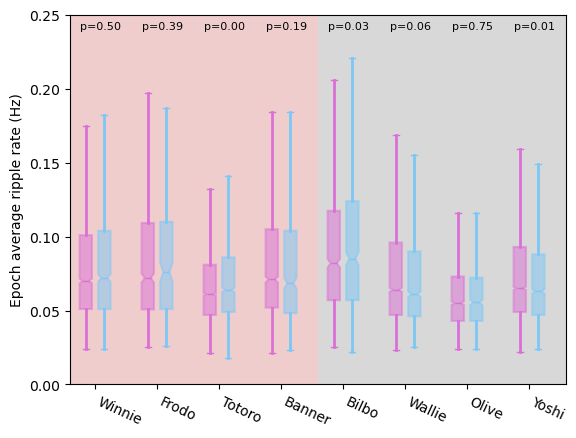

In [8]:
from scipy.stats import ttest_ind

fig = plt.figure()
ax = fig.gca()
for i, animal in enumerate(ripple_lengths):
    c = animal_style.loc[animal, "color"]
    for j, interval in enumerate(["test", "control"]):
        c = interval_style[interval]
        plt.boxplot(
            ripple_lengths[animal][interval],
            positions=[2 * i + j * 0.6],
            widths=0.4,
            patch_artist=True,
            showmeans=False,
            # showmedians=False,
            boxprops=dict(facecolor=c, alpha=0.5, edgecolor=c, lw=1.5),
            capprops=dict(color=c),
            whiskerprops=dict(color=c, lw=2),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            notch=True,
            showfliers=False,
        )

    plt.fill_between(
        [2 * i - 0.5, 2 * (i + 1) - 0.5],
        0,
        0.8,
        facecolor=animal_style.loc[animal, "background"],
        alpha=0.3,
        zorder=-1,
    )

    p_val = ttest_ind(
        ripple_lengths[animal]["test"], ripple_lengths[animal]["control"]
    ).pvalue
    plt.text(2 * i - 0.2, 0.24, f"p={p_val:.2f}", fontsize=8)
    loc = np.max(
        [
            np.max(ripple_lengths[animal]["test"]),
            np.max(ripple_lengths[animal]["control"]),
        ]
    )  # +.02
    if p_val < 0.05:
        ax.plot([2 * i, 2 * i + 1], [loc, loc], color="black", alpha=0.5, zorder=-1)
        plt.scatter([2 * i + 0.5], [loc + 0.02], color="black", marker="*")

ax.set_ylim([0, 0.25])
ax.set_xlim(-0.5, 2 * len(animal_list) - 0.5)
ax.set_xticks(2 * np.arange(len(animal_list)) + 0.3)
ax.set_xticklabels(animal_list, rotation=-25, ha="left")
plt.ylabel("Epoch average ripple rate (Hz)")
plt.show()

plt.rcParams["svg.fonttype"] = "none"
# fig.savefig(
#     "/home/sambray/Documents/MS_analysis_samsplaying/Plots/fens_2024/ripple_lengths_runs.svg",
#     format="svg",
# )

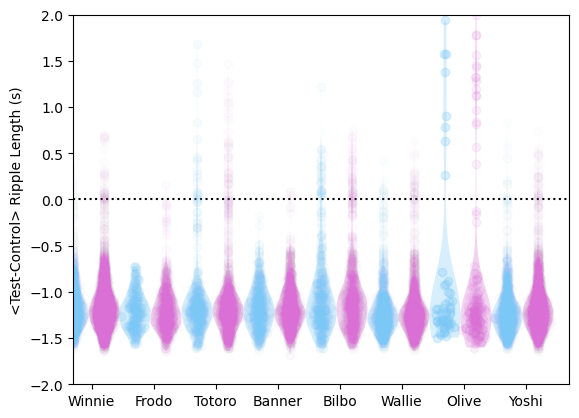

In [39]:
fig = plt.figure()
ax = fig.gca()

for i, animal in enumerate(animal_list):
    l1 = np.array(ripple_lengths[animal]["test"])
    l2 = np.array(ripple_lengths[animal]["control"])
    # l1 = l1[l1<5]
    # l2 = l2[l2<5]

    # vals = np.ravel(np.subtract.outer(l1,l2))
    # vals = vals[np.random.randint(vals.size, size=10000)]
    # violin_scatter(vals,pos=i+.5,color=animal_style.loc[animal,"color"])

    # ax.fill_between([i,i+1],-5,5,facecolor=animal_style.loc[animal,"background"],alpha=.1)
    #    break

    l1 = np.log10(l1)
    l2 = np.log10(l2)
    violin_scatter(l2, pos=i + 0.0, color=interval_style["control"])
    violin_scatter(l1, pos=i + 0.5, color=interval_style["test"])
    # break
ax.plot([0, len(animal_list)], [0, 0], color="k", ls=":", zorder=-1)
ax.set_xticks(np.arange(len(animal_list)) + 0.3, labels=animal_list)
ax.set_xlim(0, len(animal_list))
ax.set_ylim(-2, 2)
ax.set_ylabel("<Test-Control> Ripple Length (s)")
plt.rcParams["svg.fonttype"] = "none"
# fig.savefig("./Plots/ripple_length_difference.svg")
# fig.savefig("./Plots/ripple_length_absolute.svg")

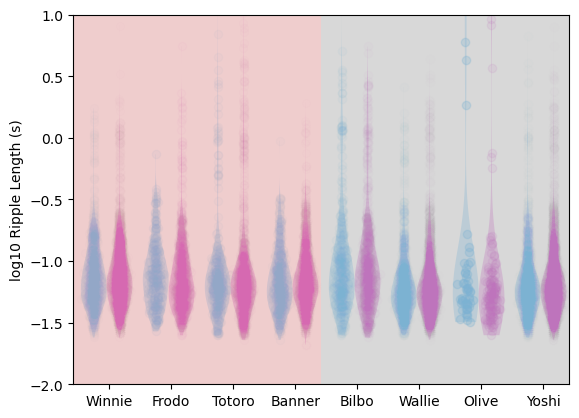

In [18]:
fig = plt.figure()
ax = fig.gca()

for i, animal in enumerate(animal_list):
    l1 = np.array(ripple_lengths[animal]["test"])
    l2 = np.array(ripple_lengths[animal]["control"])

    l1 = np.log10(l1)
    l2 = np.log10(l2)
    violin_scatter(l2, pos=i * 1.2 + 0.0, color=interval_style["control"])
    violin_scatter(l1, pos=i * 1.2 + 0.5, color=interval_style["test"])
    ax.fill_between(
        [i * 1.2 - 0.4, i * 1.2 + 0.8],
        -5,
        5,
        facecolor=animal_style.loc[animal, "background"],
        alpha=0.3,
    )
    # break

ax.set_xticks(np.arange(len(animal_list)) * 1.2 + 0.3, labels=animal_list)
ax.set_xlim(-0.4, len(animal_list) * 1.2 - 0.4)
ax.set_ylim(-2, 1)
ax.set_ylabel("log10 Ripple Length (s)")
plt.rcParams["svg.fonttype"] = "none"
fig.savefig("./Plots/ripple_length_absolute.svg")

In [107]:
len(all_ripples) == len(test_ripples) + len(control_ripples)

True

## W-track sleeps epochs

datasets: 16


Text(0.5, 1.0, 'Ripple Rate During Sleep epochs')

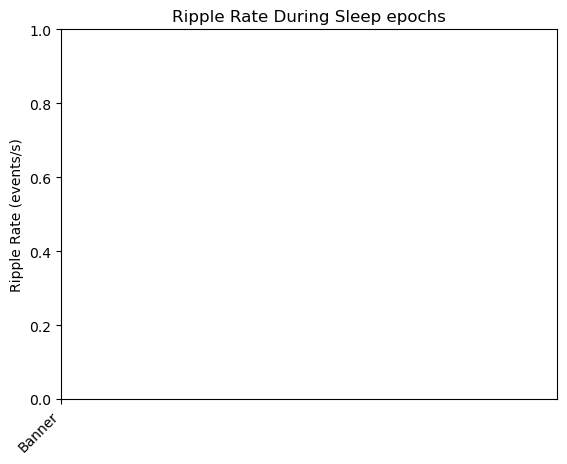

In [26]:
from spyglass.common import PositionIntervalMap, IntervalList
from spyglass.position.v1 import TrodesPosV1

animal_list = [
    # "Winnie",
    # "Frodo",
    # "Totoro",
    "Banner",
    # "Bilbo",
    # "Wallie",
    # "Olive",
    # "Yoshi",
]
filter_speed = True


for loc, animal in enumerate(animal_list):
    dataset_key = {
        "animal": animal,
        #    "period_ms":80,
        "min_pulse_length": 20,
        "track_type": "wtrack",
    }

    # get sleep interval sets
    dataset = filter_opto_data(
        dataset_key,
    )
    nwb_file_set = np.unique(dataset.fetch("nwb_file_name"))
    nwb_file_names = []
    interval_list_names = []
    for nwb_file_name in nwb_file_set:
        sleep_interval_names = (
            PositionIntervalMap
            & {
                "nwb_file_name": nwb_file_name,
            }
            & "interval_list_name LIKE '%sleep%'"
        ).fetch("position_interval_name")
        sleep_interval_names = (
            PositionIntervalMap
            & {
                "nwb_file_name": nwb_file_name,
            }
            & "interval_list_name LIKE '%sleep%'"
        ).fetch("position_interval_name")
        for interval in sleep_interval_names:
            nwb_file_names.append(nwb_file_name)
            interval_list_names.append(interval)

    ripple_rate = []
    for nwb_file_name, interval_list_name in zip(nwb_file_names, interval_list_names):
        ripple_key = {
            "nwb_file_name": nwb_file_name,
            "target_interval_list_name": f"{nwb_file_name}_{interval_list_name}_LFP_default_difference",  # interval_list_name,}
        }
        basic_key = {
            "nwb_file_name": nwb_file_name,
            "interval_list_name": interval_list_name,
        }
        if not RippleTimesV1() & ripple_key:
            print("No ripples for {}".format(ripple_key))
            continue

        ripple_df = (RippleTimesV1() & ripple_key).fetch1_dataframe()
        all_ripples = [
            [start, end] for start, end in zip(ripple_df.start_time, ripple_df.end_time)
        ]

        valid_times = (IntervalList & basic_key).fetch1("valid_times")
        # filter times when rat is stationary for rate calculation
        if filter_speed:
            # get the threshold speed from the ripple calculation
            ripple_param_name = (RippleTimesV1() & ripple_key).fetch1(
                "ripple_param_name"
            )
            thresh_speed = (
                RippleParameters() & {"ripple_param_name": ripple_param_name}
            ).fetch1("ripple_param_dict")["ripple_detection_params"]["speed_threshold"]
            # get the speed over time
            pos_df = (
                TrodesPosV1() & basic_key & {"trodes_pos_params_name": "single_led"}
            ).fetch1_dataframe()
            pos_time = pos_df.index.values
            pos_speed = pos_df.speed.values
            # make intervals where rat is stationary
            speed_binary = (pos_speed < thresh_speed).astype(int)
            speed_binary = np.append([0], speed_binary)
            if np.min(speed_binary) == 1:
                run_intervals = [(pos_time[0], pos_time[-1])]
            t_diff = np.diff(speed_binary)
            t_run_start = pos_time[np.where(t_diff == 1)[0]]
            t_run_stop = pos_time[np.where(t_diff == -1)[0]]
            stationary_intervals = [
                (start, stop) for start, stop in zip(t_run_start, t_run_stop)
            ]
            # restrict the intervals by this
            valid_times = interval_list_intersect(
                np.array(valid_times), np.array(stationary_intervals)
            )
        len_sleep = np.sum([end - start for start, end in valid_times])
        ripple_rate.append(len(all_ripples) / len_sleep)
        # if len(ripple_rate)>3:
        #     continue

    if not ripple_rate:
        continue
    violin_scatter(ripple_rate, pos=loc, color=animal_style.loc[animal, "color"])
    # plt.violinplot(ripple_rate, positions=[loc], showextrema=False, widths=.5)
    # plt.scatter(np.ones(len(ripple_rate))*loc+np.random.normal(0,.1,len(ripple_rate)), ripple_rate, alpha=.5)


plt.xticks(np.arange(len(animal_list)), animal_list, rotation=45, ha="right")
plt.ylabel("Ripple Rate (events/s)")
plt.title("Ripple Rate During Sleep epochs")

In [35]:
from spyglass.common import (
    TaskEpoch,
    convert_epoch_interval_name_to_position_interval_name,
    RawPosition,
)

sleep_interval_names
key = {
    "nwb_file_name": nwb_file_name,
}
TaskEpoch & key
RawPosition & key


# epoch = "01_sleepBan77mWnostim"
# convert_epoch_interval_name_to_position_interval_name()
# PositionIntervalMap().populate({"nwb_file_name":nwb_file_name,
#                                 "interval_list_name": "01_sleepBan77mWnostim"})

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list
Banner20220225_.nwb,pos 0 valid times
Banner20220225_.nwb,pos 1 valid times
Banner20220225_.nwb,pos 2 valid times
Banner20220225_.nwb,pos 3 valid times
Banner20220225_.nwb,pos 4 valid times
Banner20220225_.nwb,pos 5 valid times
Banner20220225_.nwb,pos 6 valid times
Banner20220225_.nwb,pos 7 valid times


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f1ca0803df0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f1ca07fb040>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f1c927e86a0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f1c927e8a90>}

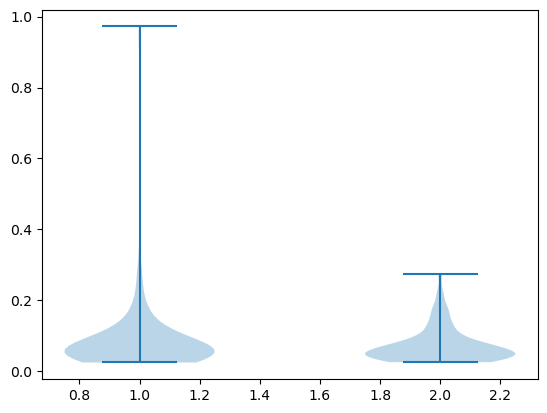

In [9]:
test_ripple_lengths = [end - start for start, end in test_ripples]
control_ripple_lengths = [end - start for start, end in control_ripples]

len_test = np.sum([end - start for start, end in test_intervals])
len_control = np.sum([end - start for start, end in control_intervals])
import matplotlib.pyplot as plt

plt.violinplot([test_ripple_lengths, control_ripple_lengths])

In [24]:
from spyglass.sharing import AnalysisNwbfileKachery

AnalysisNwbfileKachery.populate()

[11:54:16][INFO] Spyglass: Linking j1620210710_9XZG10Y7IT.nwb in kachery-cloud...
--- Logging error ---
Traceback (most recent call last):
  File "/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/sambray/mambaforge-pypy3/envs/spyglass/lib/pyth

/stelmo/nwb/.kachery-cloud/linked_files/sha1/b1/e5/93/b1e5939b1851a68b9f380c13136e12e62ee91154
/stelmo/nwb/.kachery-cloud/sha1/b1/e5/93/b1e5939b1851a68b9f380c13136e12e62ee91154


--- Logging error ---
Traceback (most recent call last):
  File "/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/logging/__init__.py", line 1083, in emit
    msg = self.format(record)
  File "/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/logging/__init__.py", line 927, in format
    return fmt.format(record)
  File "/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/logging/__init__.py", line 663, in format
    record.message = record.getMessage()
  File "/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/logging/__init__.py", line 367, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/s

/stelmo/nwb/.kachery-cloud/linked_files/sha1/50/ab/94/50ab94f88171a7581169cea8eb024afa9137b688
/stelmo/nwb/.kachery-cloud/sha1/50/ab/94/50ab94f88171a7581169cea8eb024afa9137b688
